In [13]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import requests
import asinfo

In [14]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [16]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [17]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

In [18]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_id                  
                  , audio_address
                  , audio_connect_time
                  , video_connect_time
                  , web_connect_time
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
           and successes = 1
           and failures = 0;
        '''

In [19]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [20]:
df.head()

,probe,dtime,video_id,audio_address,audio_connect_time,video_connect_time,web_connect_time
0,samsbox81,2016-09-05 16:29:41,sYf0vYkUtyA,193.212.4.15,8731,7658,6916.0
1,samsbox81,2016-09-05 16:30:23,sYf0vYkUtyA,2001:4600:9:307::f,11176,10076,17844.0
2,samsbox81,2016-09-05 17:26:17,sYf0vYkUtyA,193.212.4.15,8904,7760,7122.0
3,samsbox81,2016-09-05 17:26:59,sYf0vYkUtyA,2001:4600:9:307::f,11010,9826,17781.0
4,samsbox81,2016-09-05 18:25:53,sYf0vYkUtyA,193.212.4.15,9015,7859,8110.0


In [21]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [22]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [23]:
df = df.sort_values('dtime')

In [24]:
df.head()

,probe,dtime,video_id,audio_address,audio_connect_time,video_connect_time,web_connect_time
3036654,samsbox24,2014-08-20 01:00:00,u5KQQWlIgGc,173.194.137.147,17455,16764,NaN
3036655,samsbox24,2014-08-20 04:00:00,u5KQQWlIgGc,173.194.137.147,17501,19992,NaN
3036656,samsbox24,2014-08-20 06:00:00,u5KQQWlIgGc,173.194.137.147,17105,17226,NaN
3036657,samsbox24,2014-08-20 08:00:00,u5KQQWlIgGc,173.194.137.147,17100,20053,NaN
3036658,samsbox24,2014-08-20 09:00:00,u5KQQWlIgGc,173.194.137.147,19009,19057,NaN


In [25]:
df.tail()

,probe,dtime,video_id,audio_address,audio_connect_time,video_connect_time,web_connect_time
1979966,samsbox60,2017-06-27 23:00:00,qzlGB3eOjlU,173.194.61.40,19639,18952,22594.0
2942273,samsbox93,2017-06-27 23:00:00,qzlGB3eOjlU,2607:f8b0:400a:14::8,19854,18706,28582.0
2409424,samsbox98,2017-06-27 23:00:00,qzlGB3eOjlU,173.194.160.152,19514,18347,23838.0
3481891,samsbox75,2017-06-27 23:00:00,qzlGB3eOjlU,74.125.13.42,1640,1116,1652.0
4422464,samsbox91,2017-06-27 23:00:00,qzlGB3eOjlU,62.231.78.13,6344,5199,19917.0


In [26]:
num_probes = len(set(df['probe']))

In [27]:
df.count()

probe                 4422465
dtime                 4422465
video_id              4422465
audio_address         4416948
audio_connect_time    4422465
video_connect_time    4422465
web_connect_time      4346299
dtype: int64

In [28]:
df = df.dropna()

In [29]:
df.count()

probe                 4341008
dtime                 4341008
video_id              4341008
audio_address         4341008
audio_connect_time    4341008
video_connect_time    4341008
web_connect_time      4341008
dtype: int64

In [30]:
def filter_by_ip(df, column):
  """reads a DataFrame, calls fbi.filter_v{4,6} to get DataFrames with rows
     containing only v4, v6 endpoints. Returns the two DataFrame as a tuple"""

  dfv6 = fbi.filter_v6(df, column)
  dfv4 = fbi.filter_v4(df, column)
  return dfv4, dfv6

In [31]:
dfv4, dfv6 = filter_by_ip(df, column = 'audio_address')

In [32]:
dfv4['name'] = dfv4['probe'].apply(lambda name: "#%02d"%int(name[7:]))
dfv6['name'] = dfv6['probe'].apply(lambda name: "#%02d"%int(name[7:]))
del dfv4['probe']; del dfv6['probe']

In [33]:
dfv4.head()

,dtime,video_id,audio_address,audio_connect_time,video_connect_time,web_connect_time,name
3037786,2014-12-10 12:00:00,dOyJqGtP-wU,74.125.105.178,17384,17224,16265.0,#24
12246,2014-12-10 12:00:00,dOyJqGtP-wU,64.15.112.79,16168,16517,17429.0,#02
2117093,2014-12-10 12:00:00,dOyJqGtP-wU,149.3.177.111,38650,37155,35657.0,#06
4302454,2014-12-10 13:00:00,dOyJqGtP-wU,74.125.15.82,36044,33055,40688.0,#11
4302453,2014-12-10 13:00:00,dOyJqGtP-wU,83.255.235.15,12199,12613,19168.0,#11


In [34]:
dfv6.head()

,dtime,video_id,audio_address,audio_connect_time,video_connect_time,web_connect_time,name
2265090,2014-12-10 12:00:00,dOyJqGtP-wU,2a00:1450:4005:6::12,21590,21763,29924.0,#04
3987059,2014-12-10 12:00:00,dOyJqGtP-wU,2a00:1450:400a:6::12,53338,52224,5203.0,#16
1779714,2014-12-10 12:00:00,dOyJqGtP-wU,2a00:1450:4009:29::12,41047,41498,57187.0,#07
1779713,2014-12-10 12:00:00,dOyJqGtP-wU,2a00:1450:4003:15::12,61707,61746,25108.0,#07
3844417,2014-12-10 12:00:00,dOyJqGtP-wU,2001:1a80:100:1c::c,13701,13842,15060.0,#03


In [35]:
df = pd.merge(dfv4, dfv6, on=["name","dtime", "video_id"])
df.rename(columns={  'audio_address_x': 'audio_ep_v4'
                   , 'audio_connect_time_x': 'audio_connect_time_v4'
                   , 'video_connect_time_x': 'video_connect_time_v4'
                   , 'web_connect_time_x': 'web_connect_time_v4'                   
                   , 'audio_address_y': 'audio_ep_v6'
                   , 'audio_connect_time_y': 'audio_connect_time_v6'
                   , 'video_connect_time_y': 'video_connect_time_v6'
                   , 'web_connect_time_y': 'web_connect_time_v6'                                      
                  } ,  inplace=True)

In [36]:
df['v6_audio_status'] = 0
df['v4_audio_status'] = 0

In [37]:
df.head()

,dtime,video_id,audio_ep_v4,audio_connect_time_v4,video_connect_time_v4,web_connect_time_v4,name,audio_ep_v6,audio_connect_time_v6,video_connect_time_v6,web_connect_time_v6,v6_audio_status,v4_audio_status
0,2014-12-10 12:00:00,dOyJqGtP-wU,64.15.112.79,16168,16517,17429.0,#02,2a00:1450:4005:6::12,13244,13598,16136.0,0,0
1,2014-12-10 12:00:00,dOyJqGtP-wU,149.3.177.111,38650,37155,35657.0,#06,2a00:1450:4002:9::12,35595,34203,36757.0,0,0
2,2014-12-10 13:00:00,dOyJqGtP-wU,149.3.177.111,39748,37298,34160.0,#06,2a00:1450:4002:9::12,36146,35134,40201.0,0,0
3,2014-12-10 13:00:00,dOyJqGtP-wU,202.224.62.79,21983,22085,22511.0,#12,2404:6800:400a:8::12,38578,38122,47443.0,0,0
4,2014-12-10 13:00:00,dOyJqGtP-wU,202.224.62.79,21983,22085,22511.0,#12,2a00:1450:4009:29::12,265018,267132,46896.0,0,0


In [38]:
df.count()

dtime                    6545635
video_id                 6545635
audio_ep_v4              6545635
audio_connect_time_v4    6545635
video_connect_time_v4    6545635
web_connect_time_v4      6545635
name                     6545635
audio_ep_v6              6545635
audio_connect_time_v6    6545635
video_connect_time_v6    6545635
web_connect_time_v6      6545635
v6_audio_status          6545635
v4_audio_status          6545635
dtype: int64

In [39]:
df['v4v6_audio_connect_time'] = df.audio_connect_time_v4.map(str) + ',' + df.audio_connect_time_v6.map(str)
df['v4v6_video_connect_time'] = df.video_connect_time_v4.map(str) + ',' + df.video_connect_time_v6.map(str)
df['v4v6_web_connect_time']   = df.web_connect_time_v4.map(str) + ',' + df.web_connect_time_v6.map(str)

In [40]:
df.head()

,dtime,video_id,audio_ep_v4,audio_connect_time_v4,video_connect_time_v4,web_connect_time_v4,name,audio_ep_v6,audio_connect_time_v6,video_connect_time_v6,web_connect_time_v6,v6_audio_status,v4_audio_status,v4v6_audio_connect_time,v4v6_video_connect_time,v4v6_web_connect_time
0,2014-12-10 12:00:00,dOyJqGtP-wU,64.15.112.79,16168,16517,17429.0,#02,2a00:1450:4005:6::12,13244,13598,16136.0,0,0,"16168,13244","16517,13598","17429.0,16136.0"
1,2014-12-10 12:00:00,dOyJqGtP-wU,149.3.177.111,38650,37155,35657.0,#06,2a00:1450:4002:9::12,35595,34203,36757.0,0,0,"38650,35595","37155,34203","35657.0,36757.0"
2,2014-12-10 13:00:00,dOyJqGtP-wU,149.3.177.111,39748,37298,34160.0,#06,2a00:1450:4002:9::12,36146,35134,40201.0,0,0,"39748,36146","37298,35134","34160.0,40201.0"
3,2014-12-10 13:00:00,dOyJqGtP-wU,202.224.62.79,21983,22085,22511.0,#12,2404:6800:400a:8::12,38578,38122,47443.0,0,0,"21983,38578","22085,38122","22511.0,47443.0"
4,2014-12-10 13:00:00,dOyJqGtP-wU,202.224.62.79,21983,22085,22511.0,#12,2a00:1450:4009:29::12,265018,267132,46896.0,0,0,"21983,265018","22085,267132","22511.0,46896.0"


In [41]:
def cal_he_preference(first_family, second_family):
    if (first_family < 300000) or (first_family <= second_family + 300000): v4_status, v6_status = 0,1
    elif second_family < (first_family - 300000): v4_status, v6_status = 1,0
    return v4_status, v6_status

In [42]:
def return_preferred_af(v4v6_connect_time):
    v4, v6 = v4v6_connect_time.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_connect_time)
    v4_status, v6_status = cal_he_preference(v6, v4)
    if v4_status is not None and v6_status is not None:
        if   v4_status == 1 and v6_status == 0: return 'v4'
        elif v4_status == 0 and v6_status == 1: return 'v6'
        else: raise Exception(v4_status, v6_status)

df['audio_preferred_af'] = df['v4v6_audio_connect_time'].apply(return_preferred_af)
df['video_preferred_af'] = df['v4v6_video_connect_time'].apply(return_preferred_af)
df['web_preferred_af'] = df['v4v6_web_connect_time'].apply(return_preferred_af)

In [43]:
df.head()

,dtime,video_id,audio_ep_v4,audio_connect_time_v4,video_connect_time_v4,web_connect_time_v4,name,audio_ep_v6,audio_connect_time_v6,video_connect_time_v6,web_connect_time_v6,v6_audio_status,v4_audio_status,v4v6_audio_connect_time,v4v6_video_connect_time,v4v6_web_connect_time,audio_preferred_af,video_preferred_af,web_preferred_af
0,2014-12-10 12:00:00,dOyJqGtP-wU,64.15.112.79,16168,16517,17429.0,#02,2a00:1450:4005:6::12,13244,13598,16136.0,0,0,"16168,13244","16517,13598","17429.0,16136.0",v6,v6,v6
1,2014-12-10 12:00:00,dOyJqGtP-wU,149.3.177.111,38650,37155,35657.0,#06,2a00:1450:4002:9::12,35595,34203,36757.0,0,0,"38650,35595","37155,34203","35657.0,36757.0",v6,v6,v6
2,2014-12-10 13:00:00,dOyJqGtP-wU,149.3.177.111,39748,37298,34160.0,#06,2a00:1450:4002:9::12,36146,35134,40201.0,0,0,"39748,36146","37298,35134","34160.0,40201.0",v6,v6,v6
3,2014-12-10 13:00:00,dOyJqGtP-wU,202.224.62.79,21983,22085,22511.0,#12,2404:6800:400a:8::12,38578,38122,47443.0,0,0,"21983,38578","22085,38122","22511.0,47443.0",v6,v6,v6
4,2014-12-10 13:00:00,dOyJqGtP-wU,202.224.62.79,21983,22085,22511.0,#12,2a00:1450:4009:29::12,265018,267132,46896.0,0,0,"21983,265018","22085,267132","22511.0,46896.0",v6,v6,v6


In [44]:
def cal_v4_status(af):
    if af == 'v4': return 1
    else: return 0
    
def cal_v6_status(af):
    if af == 'v6': return 1
    else: return 0    

df['v4_audio_status'] = df['audio_preferred_af'].apply(cal_v4_status)
df['v6_audio_status'] = df['audio_preferred_af'].apply(cal_v6_status)
df['v4_video_status'] = df['video_preferred_af'].apply(cal_v4_status)
df['v6_video_status'] = df['video_preferred_af'].apply(cal_v6_status)
df['v4_web_status'] = df['web_preferred_af'].apply(cal_v4_status)
df['v6_web_status'] = df['web_preferred_af'].apply(cal_v6_status)

In [45]:
del df['v4v6_audio_connect_time']; del df['audio_preferred_af']
del df['v4v6_video_connect_time']; del df['video_preferred_af']
del df['v4v6_web_connect_time']; del df['web_preferred_af']
df.head()

,dtime,video_id,audio_ep_v4,audio_connect_time_v4,video_connect_time_v4,web_connect_time_v4,name,audio_ep_v6,audio_connect_time_v6,video_connect_time_v6,web_connect_time_v6,v6_audio_status,v4_audio_status,v4_video_status,v6_video_status,v4_web_status,v6_web_status
0,2014-12-10 12:00:00,dOyJqGtP-wU,64.15.112.79,16168,16517,17429.0,#02,2a00:1450:4005:6::12,13244,13598,16136.0,1,0,0,1,0,1
1,2014-12-10 12:00:00,dOyJqGtP-wU,149.3.177.111,38650,37155,35657.0,#06,2a00:1450:4002:9::12,35595,34203,36757.0,1,0,0,1,0,1
2,2014-12-10 13:00:00,dOyJqGtP-wU,149.3.177.111,39748,37298,34160.0,#06,2a00:1450:4002:9::12,36146,35134,40201.0,1,0,0,1,0,1
3,2014-12-10 13:00:00,dOyJqGtP-wU,202.224.62.79,21983,22085,22511.0,#12,2404:6800:400a:8::12,38578,38122,47443.0,1,0,0,1,0,1
4,2014-12-10 13:00:00,dOyJqGtP-wU,202.224.62.79,21983,22085,22511.0,#12,2a00:1450:4009:29::12,265018,267132,46896.0,1,0,0,1,0,1


In [46]:
import clusterbycolumn as cbc
dfgroupby = cbc.group(df, column='video_id')

In [47]:
df_audio_agg = cbc.aggregate(dfgroupby, ['v4_audio_status', 'v6_audio_status'], ['sum'])
df_video_agg = cbc.aggregate(dfgroupby, ['v4_video_status', 'v6_video_status'], ['sum'])
df_web_agg   = cbc.aggregate(dfgroupby, ['v4_web_status', 'v6_web_status'], ['sum'])

In [48]:
def cal_preference(df_agg):
    mydict = {}
    for idx, series in df_agg.iterrows():
        v4counter = series[0]
        v6counter = series[1]
        v4v6sum = v6counter + v4counter
        try:
            v4percent = 100.0 * v4counter / v4v6sum
            v6percent = 100.0 * v6counter / v4v6sum
        except ZeroDivisionError: 
            # this can happen when all of the v4 and v6 endpoints timedout, resulting in no time values
            v4percent = v6percent = 0
        mydict[idx] = (v4percent, v6percent)    
    return mydict

audio_dict = cal_preference(df_audio_agg)
video_dict = cal_preference(df_video_agg)
web_dict = cal_preference(df_web_agg)

In [49]:
from collections import defaultdict
mydict = defaultdict(list)

for d in (web_dict, audio_dict, video_dict):
    for key, value in d.items():
        mydict[key].append(value)

In [50]:
df = pd.DataFrame.from_dict(mydict, orient='index', dtype=None)
df = df.rename(columns = {0: 'web', 1: 'audio', 2: 'video'})

In [51]:
df['web_v4_preference'] = df['web'].apply(lambda x: x[0])
df['web_v6_preference'] = df['web'].apply(lambda x: x[1])

df['audio_v4_preference'] = df['audio'].apply(lambda x: x[0])
df['audio_v6_preference'] = df['audio'].apply(lambda x: x[1])

df['video_v4_preference'] = df['video'].apply(lambda x: x[0])
df['video_v6_preference'] = df['video'].apply(lambda x: x[1])

del df['web']
del df['audio']
del df['video']

In [52]:
df.head()

,web_v4_preference,web_v6_preference,audio_v4_preference,audio_v6_preference,video_v4_preference,video_v6_preference
EctkLeyz8Ks,0.000000,100.000000,0.000000,100.000000,0.000000,100.000000
6x2dzepmU8o,0.724930,99.275070,0.161095,99.838905,0.161095,99.838905
I897Lk4bJkE,0.403769,99.596231,0.000000,100.000000,0.134590,99.865410
aSsH6tYBgD8,0.292398,99.707602,0.194932,99.805068,0.000000,100.000000
cRbqf_2JN4E,0.952381,99.047619,1.714286,98.285714,1.333333,98.666667


In [53]:
num_videos = df['video_v6_preference'].count()

In [54]:
import Cdf
import Pmf

sample = df['video_v6_preference'].values
c_v = Cdf.MakeCdfFromList(sample)
cc_v = [1 - p for x, p in c_v.Items()]

sample = df['audio_v6_preference'].values
c_a = Cdf.MakeCdfFromList(sample)
cc_a = [1 - p for x, p in c_a.Items()]

sample = df['web_v6_preference'].values
c_w = Cdf.MakeCdfFromList(sample)
cc_w = [1 - p for x, p in c_w.Items()]

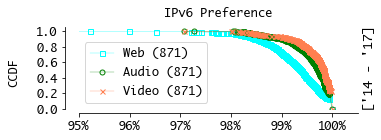

In [55]:
fig = plt.figure(figsize = (5, 1.5))
plt.rcParams['font.size'] = 12
ax = plt.gca()
yticks = np.arange(0,1.1,0.2)
xticks = np.arange(0,110,10)

plt.plot(c_w.xs, cc_w, marker='s', linewidth=0.3, markersize=5, fillstyle='none', color = 'Cyan')
plt.plot(c_a.xs, cc_a, marker='o', linewidth=0.3, markersize=5, fillstyle='none', color = 'Green')
plt.plot(c_v.xs, cc_v, marker='x', linewidth=0.3, markersize=5, fillstyle='none', color = 'Coral')

ax.yaxis.set_label_coords(-0.21, 0.45)
ax = fig.axes[0]
ax.grid(False)
ax.set_yticks(yticks)
ax.set_xticks(xticks)
ax.set_ylim([0,1.05])
ax.set_xlim([95,100.5])
ax.set_xscale('linear')
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('CCDF', fontsize=12)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax2 = ax.twinx()
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_ylabel('[\'14 - \'17]', fontsize = 13)
plt.setp( ax2.get_yticklabels(), visible=False)

ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))
ax.legend(['Web (%d)'%num_videos, 'Audio (%d)'%num_videos, 'Video (%d)'%num_videos], fontsize=12, loc='lower left')

def to_percent(x, position): return str(int(x)) + '%'
ax.xaxis.set_major_formatter(FuncFormatter(to_percent))

plt.title('IPv6 Preference', fontsize=12, y=1.05)
plt.savefig('he-preference-videos-ccdf.pdf', format='pdf', bbox_inches='tight')

In [56]:
with open('he-preference-video.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c_v.xs, cc_v): f.write('%.2f; %.2f\n'%(x,y))
        
with open('he-preference-audio.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c_a.xs, cc_a): f.write('%.2f; %.2f\n'%(x,y))        
        
with open('he-preference-web.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c_w.xs, cc_w): f.write('%.2f; %.2f\n'%(x,y))                